## MNIST with knn

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")
# State of the art accuracy 99.79% accuracy

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
mnist.test.labels[0]

7

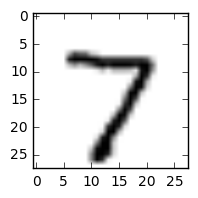

In [3]:
plt.figure(figsize=(2,2))
plt.imshow(1.0-mnist.test.images[0,:].reshape(28,28),cmap="gray")

In [4]:
# Exerise
# Produce one-hot-encoding
Y_test = None
Y_train = None
Y_test = np.zeros((mnist.test.labels.shape[0],10))
for i in mnist.test.labels:
    Y_test[i,mnist.test.labels[i]] = 1
# Nicer way without for loop
Y_train = np.zeros((len(mnist.train.labels),10))
Y_train[np.arange(len(mnist.train.labels)),mnist.train.labels] = 1


In [14]:
# Exercise
# For each label (0..9) compute and draw the images' centroids, i.e. the "average" bitmaps

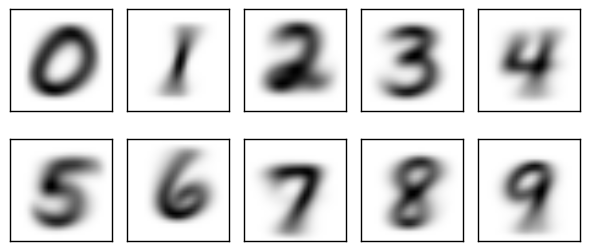

In [5]:
def average_centroid_digit(n):
    return mnist.train.images[mnist.train.labels == n].mean(axis=0).reshape(28, 28)

fig, axes = plt.subplots(2, 5, figsize=(6, 3))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(1 - average_centroid_digit(i), cmap='gray')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(length=0)
fig.tight_layout()

In [6]:
# Write knn algorithm
from scipy.spatial.distance import cdist
from scipy.stats import mode

def knn(X_train, Y_train, x, k=5): # k-nearest neighbor classifier
    """
    In our case we have: X_train: 55000x784 matrix,
                         Y_train: 50000 corresponding labels in {0,1,...,9}
                         x - vector of length 784 to be classified (a single point)
    returns: a signe label
    """
    # 1. compute the distances between x and each point in X_train
    d = cdist(X_train, x.reshape(1,-1))
    # 2. find the k smallest distances (find the k closest points to x in X_train)
    i = np.argsort(d, axis=None)[:k]
    # 3. get k corresponding labels in Y_train
    l = Y_train[i]
    # 4. return the mode of the k labels
    return mode(l,axis=None)[0][0]   

In [ ]:
# Test the function on one example
knn(mnist.train.images, mnist.train.labels, mnist.test.images[0,:]), mnist.test.labels[0]

(7, 7)

In [ ]:
limit = 10000 # how many of the test data to handle, to speed up process
Y_pred = np.array(
    [knn(mnist.train.images, mnist.train.labels, mnist.test.images[i,:],k=15) for i in range(limit)]
)
print("Accurcary: %.4f" % np.mean(Y_pred == mnist.test.labels[:limit]))

## Gradient descent

In [7]:
def f(x, y):
    return np.sin(0.5*x**2-0.25*y**2+3)*np.cos(2*x+1-np.exp(y))

def f_grad(x, y, h=0.001):
    return np.r_[
        (f(x+h, y)-f(x,y))/h,
        (f(x, y+h)-f(x,y))/h,
    ]

def grad_descent(x0, y0, f, f_grad, c=0.01, maxiter=1000):
    xy = np.r_[x0, y0]
    for i in range(maxiter):
        xy -= c*f_grad(xy[0], xy[1])
        plt.plot(xy[0], xy[1], "ro")
    return xy[0], xy[1]

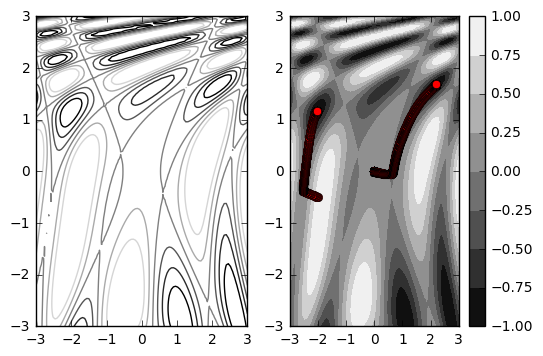

2.1986976603 1.68525160698 -0.999979670784
-2.02885887707 1.17073520629 -0.99999461533


In [8]:
x = y = np.linspace(-3, 3, 101)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

plt.subplot(121)
plt.contour(X, Y, Z, cmap="gray")
plt.subplot(122)
CS = plt.contourf(X, Y, Z, cmap="gray")

x1, y1 = grad_descent(0.0, 0.0, f, f_grad,maxiter=3000)
x2, y2 = grad_descent(-2.0, -0.5, f, f_grad,maxiter=3000)

plt.colorbar(CS)
plt.show()

print(x1, y1, f(x1, y1))
print(x2, y2, f(x2, y2))

## MNIST classification based on handmade neural nets (multinomial logistic regression)

In [9]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
X_train = np.insert(mnist.train.images, 784, 1, axis=1)
X_test  = np.insert(mnist.test.images,  784, 1, axis=1)
Y_train = mnist.train.labels
Y_test  = mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [10]:
def softmax(x):
    y = np.exp(x)
    return y / np.sum(y, axis=1).reshape(-1,1)

In [11]:
def accur(W,X,Y):
    return np.mean(np.argmax(softmax(X.dot(W)), axis=1) == np.argmax(Y,axis=1))

In [12]:
def cross_entropy(W,X,Y):
    return -np.sum(np.log(softmax(X.dot(W))) * Y )/ X.shape[0]

In [13]:
def cross_entropy_grad(W, X, Y):
    return (-X.T.dot(Y-softmax(X.dot(W))))/X.shape[0]

In [14]:
import time

np.random.seed(123)
k = 0.5
maxiter = 250

W = np.random.normal(size=(785,10))

start = time.time()

for i in range(maxiter):
    
    # Gradient descent
    W = W - k*cross_entropy_grad(W, X_train, Y_train)
    
    if i%50 == 0:
        print("Step i=%3d Loss function= %.3f Accuracy= %.4f" % (i,cross_entropy(W,X_train,Y_train),accur(W, X_train, Y_train)))
print("\bTest accuracy=%.3f" % accur(W,X_test,Y_test))

print(time.time()-start)

Step i=  0 Loss function= 10.536 Accuracy= 0.1716
Step i= 50 Loss function= 2.035 Accuracy= 0.6321
Step i=100 Loss function= 1.350 Accuracy= 0.7314
Step i=150 Loss function= 1.090 Accuracy= 0.7742
Step i=200 Loss function= 0.951 Accuracy= 0.7991
Test accuracy=0.824
55.491522550582886


In [15]:
import time

np.random.seed(123)
k = 0.5
maxiter = 250
s = 100
delta_s = X_train.shape[0]//s
W = np.random.normal(size=(785,10))

start = time.time()

for i in range(maxiter):
    
    # Stochastic gradient descent
    for j in range(s):
        X = X_train[(j*delta_s):((j+1)*delta_s),:]
        Y = Y_train[(j*delta_s):((j+1)*delta_s),:]
        W = W - k*cross_entropy_grad(W,X,Y)
    
    if i%50 == 0:
        print("Step i=%3d Loss function= %.3f Accuracy= %.4f" % (i,cross_entropy(W,X_train,Y_train),accur(W, X_train, Y_train)))
print("\bTest accuracy=%.3f" % accur(W,X_test,Y_test))

print(time.time()-start)

Step i=  0 Loss function= 1.360 Accuracy= 0.7308
Step i= 50 Loss function= 0.324 Accuracy= 0.9141
Step i=100 Loss function= 0.279 Accuracy= 0.9242
Step i=150 Loss function= 0.261 Accuracy= 0.9290
Step i=200 Loss function= 0.250 Accuracy= 0.9313
Test accuracy=0.921
61.30306434631348


## MNIST with tensorflow

In [16]:
import tensorflow as tf
x = tf.placeholder(tf.float32,[None,785])
y = tf.placeholder(tf.float32,[None,10])
W = tf.Variable(tf.zeros([785,10],dtype=tf.float32))

y_pred = tf.nn.softmax(tf.matmul(x,W))

cross_entropy = -tf.reduce_sum(
    tf.log(y_pred) * y
) / tf.cast(tf.shape(x)[0],tf.float32)

accuracy = tf.reduce_mean(tf.cast(
        tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1)),
    tf.float32)
)

In [17]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [19]:
import time

np.random.seed(123)
k = 0.5
maxiter = 250
s = 100
delta_s = X_train.shape[0]//s
W = np.random.normal(size=(785,10))

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

start = time.time()
for i in range(maxiter):
    
    # Stochastic gradient descent
    for j in range(s):
        sess.run(train_step, feed_dict={
                x: X_train[(j*delta_s):((j+1)*delta_s),:],
                y: Y_train[(j*delta_s):((j+1)*delta_s),:],
            })
    
    if i%50 == 0:
        print("%3d: %.5f %.5f %.5f" % (i,
                                       sess.run(cross_entropy, feed_dict={
                                            x: X_train,
                                            y: Y_train
                                        }),
                                        sess.run(accuracy, feed_dict={
                                            x: X_train,
                                            y: Y_train
                                        }),
                                        sess.run(accuracy, feed_dict={
                                            x: X_test,
                                            y: Y_test
                                        })
                                       ))


print(time.time()-start)

  0: 0.39783 0.88876 0.89870
 50: 0.25397 0.92936 0.92390
100: 0.24363 0.93244 0.92520
150: 0.23827 0.93396 0.92520
200: 0.23477 0.93469 0.92500
69.43997955322266
